# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [39]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider the **standard OLG-model** where:

We assume that utility is given by $u(c)$ with constant relative risk aversion (CRRA utility function): 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

Individuals live for two periods, t = 1,2. $L_t$ individuals are born in period t and we assume that the population grows with a constant rate, n: 

$$ L_t = L_{t-1}(1+n) $$

agents derive utility while alive: 

$$ U_t = u(c_{1t})+\frac{1}{1+\rho} u(c_{2t}) $$

Agtens' budget constraint in each period is given by: 

$$ c_{1t} + s_t = w_t $$

$$ c_{2t+1} = (1+r_{t+1}) s_t $$

This implies that agents' lifetime budget constraint is given by: 

$$ c_{1t} + \frac{c_{2t+1}}{1+r_{t+1}} = w_t $$



# Analytical solution

## Household problem

Every agtens born at time t maximize utility subject to their lifetime budget constraint:

First we define all **symbols**:

In [40]:
c_1t = sm.symbols('c_1t')
c_2t = sm.symbols('c_2t+1')
rho = sm.symbols('rho')
u_1 = sm.symbols('u_1')
u_2 = sm.symbols('u_2')
sigma = sm.symbols('sigma')
w = sm.symbols('w_t')
r_t1 = sm.symbols('r_t+1')
lamb = sm.symbols('lambda')
s = sm.symbols('s_t')
k_t2 = sm.symbols('k_t+1')
k_t1 = sm.symbols('k_t')
alpha = sm.symbols('alpha')

In [41]:
#Lifetime utility
u_c1 = sm.ln(c_1t)
u_c2 = sm.ln(c_2t)
U = u_c1 + u_c2/(1+rho)
U

log(c_1t) + log(c_2t+1)/(rho + 1)

In [42]:
# Lagrangian
budget_l = c_1t + c_2t/(1+r_t1) - w
L = U - lamb * budget_l
L



-lambda*(c_1t + c_2t+1/(r_t+1 + 1) - w_t) + log(c_1t) + log(c_2t+1)/(rho + 1)

In [43]:
def Lan(x):
    L_1 = sm.diff(L, x)
    L_2 = sm.Eq(L_1,0)
    L_3 = sm.solve(L_2, lamb) [0]
    return L_3

L_c1 = Lan(c_1t)
L_c2 = Lan(c_2t)

Eu = sm.Eq(L_c1, L_c2)
Eu_1 = sm.solve(Eu, c_2t) [0]
Euler = sm.Eq(c_2t, Eu_1)
Euler




Eq(c_2t+1, c_1t*(r_t+1 + 1)/(rho + 1))

In [44]:
budget_1 = w-s 
budget_2 = (1+r_t1)*s

savings_1 = Euler.subs(c_1t,budget_1)

savings_2 = savings_1.subs(c_2t, budget_2)

savings = sm.solve(savings_2,s)[0]

opt_savings = sm.Eq(s,savings)
opt_savings

Eq(s_t, w_t/(rho + 2))

For later use, we turn the solution into a **Python funciton**

In [45]:
ss_func = sm.lambdify((s,g,n,alpha,delta),kss)

NameError: name 'g' is not defined

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [46]:
w = 2
r = 0.05
sigma = 0.9
rho = 0.05

**Solve numerically** for the steady state:

In [55]:
def c_1(w,s):
    return w-s

def c_2(s,r):
    return (1+r)*s

def u_func(c,sigma):
    if sigma == 1:
        u = np.log(c)
    else:
        u = (c**(1-sigma)-1)/(1-sigma)
    return u

def utility(sigma,rho,w,r,s):
    return u_func(w-s,sigma) + 1/(1+rho)*u_func((1+r)*s,sigma)

solvers

In [56]:
def solve_consumer_problem(sigma,rho,w,r,s):

    # a. grids
    w_vec = np.linspace(12000,40000,500)
    s_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,w in enumerate(w_vec):

        # i. objective
        obj = lambda s: -utility(sigma,rho,w,r,s)

        # ii. initial value (consume half)
        s = 0.01

        # iii. optimizer
        result = optimize.minimize_scalar(obj,s,method='bounded',bounds=[1e-8,w])

        # iv. save
        #utility_vec[i] = -result.fun
        s_vec[i] = result.x
        
    return w_vec,s_vec


In [57]:
# Find solution
w_vec,s_vec = solve_consumer_problem(sigma,rho,w,r,s)

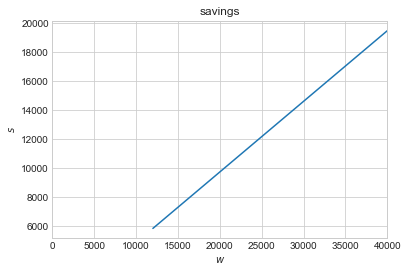

In [58]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,s_vec)
ax.set_xlabel('$w$')
ax.set_ylabel('$s$')
ax.set_title('savings')
ax.set_xlim([0,40000]);

## to typer

In [59]:
w_vec1,s_vec1 = solve_consumer_problem(sigma,0.1,w,r,s)
w_vec2,s_vec2 = solve_consumer_problem(sigma,0.7,w,r,s)

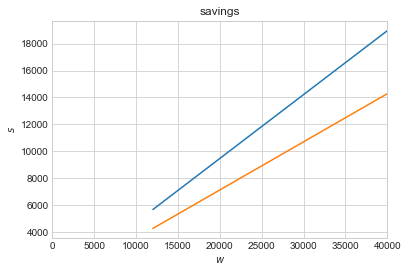

In [60]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec1,s_vec1)
ax.plot(w_vec2,s_vec2)
ax.set_xlabel('$w$')
ax.set_ylabel('$s$')
ax.set_title('savings')
ax.set_xlim([0,40000]);

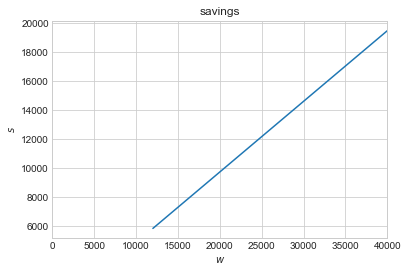

In [71]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,s_vec)
ax.set_xlabel('$w$')
ax.set_ylabel('$s$')
ax.set_title('savings')
ax.set_xlim([0,40000]);

## noget med en skat

In [51]:
def t_wages(w):
    if w > 30000:
        taxed_w = (1-0.35)*30000+(1-0.15)*(w-30000)
    else:
        taxed_w = (1-0.35)*w
    return taxed_w

In [52]:
def solve_consumer_problem2(sigma,rho,w,r,s):

    # a. grids
    w_vec = np.linspace(12000,40000,500)
    s_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,w in enumerate(w_vec):

        # i. objective
        obj = lambda s: -utility(sigma,rho,t_wages(w),r,s)

        # ii. initial value (consume half)
        s = 0.01

        # iii. optimizer
        result = optimize.minimize_scalar(obj,s,method='bounded',bounds=[1e-8,w])

        # iv. save
        #utility_vec[i] = -result.fun
        s_vec[i] = result.x
        
    return w_vec,s_vec

In [53]:
w_vec,s_vec = solve_consumer_problem2(sigma,rho,w,r,s)

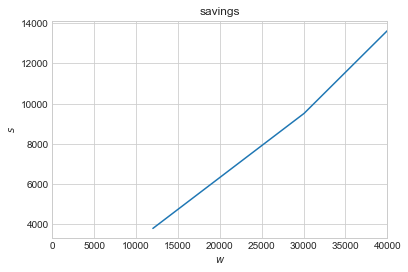

In [54]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,s_vec)
ax.set_xlabel('$w$')
ax.set_ylabel('$s$')
ax.set_title('savings')
ax.set_xlim([0,40000]);

# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.